In [3]:
import gensim
from glove_code.src.glove import Glove
from gensim.models.callbacks import LossLogger, LossSetter
from gensim.models.keyedvectors import PoincareWordEmbeddingsKeyedVectors as pkv
from gensim.matutils import argsort
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot
from operator import itemgetter
import os
import random
from scipy import stats
random.seed(42)

ROOT = "/Users/alext/Documents/Master/Thesis/"

In [39]:
hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_3_100_A01_a01_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_bias_burnin1")
# hyp_model_fn = os.path.join(ROOT, "models/word2vec_baseline/w2v_levy_sg_5_100_A025_a0001_n5_w5_c100_cosine_OPTsgd")
hyp_model = gensim.models.Word2Vec.load(hyp_model_fn)
hyp_wv = hyp_model.wv
hyp_wv.trainables = hyp_model.trainables
hyp_wv.use_poincare_distance = True

In [40]:
spearman, ratio, le_score_model, le_score_gold, le_info = hyp_wv.evaluate_lexical_entailment(
    os.path.join(ROOT, 'data/hyperlex-data', 'nouns-verbs/hyperlex-nouns.txt'),
    dummy4unknown=False
)
print("HyperLex - nouns: {} {}".format(spearman[0], ratio))
# all_info = sorted(list(zip(le_info, le_score_gold, le_score_model)), key=itemgetter(1), reverse=1)
# for info, gold, score in all_info[:100]:
#     print(info.lower(), gold, score)

HyperLex - nouns: 0.17429623272030015 0.18492834026814609


In [41]:
spearman, ratio, _, _, _ = hyp_wv.evaluate_lexical_entailment(
    os.path.join(ROOT, 'data/hyperlex-data', 'nouns-verbs/hyperlex-verbs.txt'),
    dummy4unknown=False
)
print("HyperLex - verbs: {} {}".format(spearman[0], ratio))

HyperLex - verbs: 0.2550654578452322 0.0


In [42]:
spearman, ratio, _, _, _ = hyp_wv.evaluate_lexical_entailment(
    os.path.join(ROOT, 'data/hyperlex-data', 'hyperlex-all.txt'),
    dummy4unknown=False
)
print("HyperLex - all: {} {}".format(spearman[0], ratio))

HyperLex - all: 0.19038158994429805 0.1529051987767584


## Hyperparameter grid search

In [43]:
spearman, ratio, _, _, _ = hyp_wv.evaluate_lexical_entailment(
    os.path.join(ROOT, 'data/hyperlex-data', 'hyperlex-all.txt'),
    dummy4unknown=False
)
print("HyperLex - all: {} {}".format(spearman[0], ratio))

HyperLex - all: 0.19038158994429805 0.1529051987767584


In [44]:
hyperlex_file = os.path.join(ROOT, "data/hyperlex-data/hyperlex-all.txt")

def read_hyperlex_format(filename):
    with open(filename, "r") as f:
        lines = [line.strip().split() for line in f.readlines()[1:]]
        result = []
        discarded_count = 0
        for line in lines:
            if line[0] not in hyp_wv.vocab or line[1] not in hyp_wv.vocab:
                discarded_count += 1
                continue
            result.append([line[0], line[1], hyp_wv.vocab[line[0]].index, hyp_wv.vocab[line[1]].index, float(line[5])])
        print("Discarded {} pairs out of {}".format(discarded_count, len(lines)))
        return np.array(result)

hyperlex = read_hyperlex_format(hyperlex_file)

print(hyperlex[:10])

Discarded 4 pairs out of 2616
[['conflict' 'disagreement' '1489' '8101' '8.67']
 ['advance' 'take' '2500' '291' '2.37']
 ['trail' 'follow' '2318' '1724' '7.18']
 ['mason' 'worker' '5595' '5323' '7.5']
 ['aura' 'light' '19766' '572' '6.15']
 ['radish' 'carrot' '66093' '25733' '0.15']
 ['tusk' 'duty' '39108' '2439' '0.13']
 ['vehicle' 'motorcycle' '2028' '5903' '1.82']
 ['veal' 'meat' '48465' '4046' '9.77']
 ['keyboard' 'arm' '5948' '3050' '0.9']]


In [49]:
def gyr_midpoint(word):
    w = hyp_wv.word_vec(word)
    c = hyp_wv.trainables.syn1neg[hyp_wv.vocab[word].index]
    
    gamma_w_sq = 1 / (1 - norm(w)**2)
    gamma_c_sq = 1 / (1 - norm(c)**2)
    denominator = gamma_w_sq + gamma_c_sq - 1
    agg = w * gamma_w_sq / denominator + c * gamma_c_sq / denominator

    return hyp_wv.moebius_mul(agg, 0.5)

def entailment_score(x, y, alpha=1, gamma=1):
    idx_x = hyp_wv.vocab[x].index
    idx_y = hyp_wv.vocab[y].index
    context_x = hyp_wv.trainables.syn1neg[idx_x]
    context_y = hyp_wv.trainables.syn1neg[idx_y]
    
#     mid_x = gyr_midpoint(x)
#     mid_y = gyr_midpoint(y)
    
#     diff = hyp_wv.distance(context_y, hyp_wv.word_vec(y)) - hyp_wv.distance(context_x, hyp_wv.word_vec(x))  # self.trainables.b1[idx_x] - self.trainables.b1[idx_y]
#     diff = hyp_wv.embedding_norm(mid_y) - hyp_wv.embedding_norm(mid_x)
#     diff = hyp_wv.embedding_norm(hyp_wv.vectors[idx_y]) - hyp_wv.embedding_norm(hyp_wv.vectors[idx_x])
    diff = hyp_wv.embedding_norm(context_y) - hyp_wv.embedding_norm(context_x)
    return -(1 + alpha * diff) * hyp_wv.distance(x, y)**gamma

In [50]:
gold_score = hyperlex[:, 4]
hyp_sim_score = [-hyp_wv.distance(w1, w2) for w1, w2 in hyperlex[:, [0,1]]]
print("SIM score:", stats.spearmanr(hyp_sim_score, gold_score))

def run_le_eval(alpha=1, gamma=1):
    hyp_score = [entailment_score(w1, w2, alpha=alpha, gamma=gamma) for w1, w2 in hyperlex[:, [0,1]]]
    print("alpha =", alpha, ", gamma =", gamma, ", LE score =", stats.spearmanr(hyp_score, gold_score)[0])

SIM score: SpearmanrResult(correlation=0.15713060543140123, pvalue=6.639856240172427e-16)


/usr/local/lib/python3.6/site-packages/scipy-1.0.1-py3.6-macosx-10.13-x86_64.egg/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [51]:
for alpha, gamma in itertools.product(np.linspace(0, 5, num=5).tolist()+[10, 100, 500, 1000], np.linspace(0.1, 5.0, num=5)):
    run_le_eval(alpha=alpha, gamma=gamma)

/usr/local/lib/python3.6/site-packages/scipy-1.0.1-py3.6-macosx-10.13-x86_64.egg/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


alpha = 0.0 , gamma = 0.1 , LE score = 0.15713306663936344
alpha = 0.0 , gamma = 1.3250000000000002 , LE score = 0.15713060543140123
alpha = 0.0 , gamma = 2.5500000000000003 , LE score = 0.15713060543140123
alpha = 0.0 , gamma = 3.7750000000000004 , LE score = 0.15713060543140123
alpha = 0.0 , gamma = 5.0 , LE score = 0.15713060543140123
alpha = 1.25 , gamma = 0.1 , LE score = 0.09693375224993622
alpha = 1.25 , gamma = 1.3250000000000002 , LE score = 0.16540174669742433
alpha = 1.25 , gamma = 2.5500000000000003 , LE score = 0.16998765647083422
alpha = 1.25 , gamma = 3.7750000000000004 , LE score = 0.16851162430279693
alpha = 1.25 , gamma = 5.0 , LE score = 0.16691367905003984
alpha = 2.5 , gamma = 0.1 , LE score = 0.09068234805492127
alpha = 2.5 , gamma = 1.3250000000000002 , LE score = 0.1447693244557002
alpha = 2.5 , gamma = 2.5500000000000003 , LE score = 0.16294147344204657
alpha = 2.5 , gamma = 3.7750000000000004 , LE score = 0.16888144674293282
alpha = 2.5 , gamma = 5.0 , LE scor

## HyperLex word freq analysis

In [4]:
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.05_vocab400000_poincare_OPTwfullrsgd_COOCCFUNClog_DISTFUNCdist-sq_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

5231
[4726, 4726, 4749, 4749, 4749, 4749, 4755, 4755, 4755, 4755, 4760, 4765, 4765, 4765, 4771, 4771, 4785, 4793, 4812, 4812, 4815, 4815, 4815, 4815, 4815, 4819, 4842, 4844, 4853, 4864, 4864, 4864, 4864, 4880, 4880, 4887, 4898, 4898, 4898, 4906, 4910, 4910, 4919, 4919, 4923, 4926, 4926, 4926, 4931, 4931, 4949, 4950, 4952, 4953, 4953, 4957, 4957, 4957, 4967, 4970, 4984, 4984, 4995, 4995, 5017, 5017, 5025, 5025, 5025, 5029, 5029, 5043, 5043, 5043, 5050, 5050, 5070, 5080, 5080, 5080, 5085, 5085, 5089, 5089, 5097, 5104, 5128, 5132, 5143, 5149, 5149, 5149, 5155, 5155, 5167, 5174, 5210, 5210, 5217, 5217, 5217, 5220, 5236, 5236, 5236, 5236, 5236, 5236, 5236, 5239, 5239, 5239, 5239, 5242, 5242, 5245, 5245, 5245, 5245, 5245, 5253, 5254, 5254, 5260, 5277, 5277, 5277, 5289, 5289, 5303, 5303, 5313, 5313, 5313, 5313, 5318, 5318, 5318, 5324, 5324, 5324, 5348, 5348, 5348, 5348, 5348, 5353, 5353, 5353, 5353, 5355, 5355, 5355, 5362, 5371, 5375, 5375, 5375, 5398, 5418, 5437, 5437, 5443, 5453, 5453, 5455

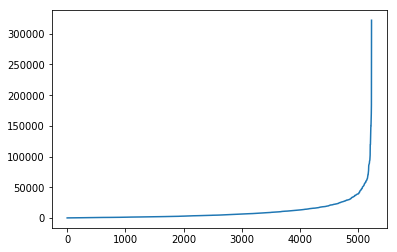

In [20]:
flatten = lambda l: [item for sublist in l for item in sublist]
with open(os.path.join(ROOT, 'data/hyperlex-data', 'hyperlex-all.txt'), "r") as f:
    words = flatten([line.strip().split(" ", 2)[:2] for line in f.readlines()[1:]])

indexes = []
for word in words:
    if word not in hyp_wv.vocab:
        continue
    indexes.append(hyp_wv.vocab[word].index)
    
indexes = sorted(indexes)
plt.plot(range(len(indexes)), indexes)
print(len(indexes))
print(indexes[-2600:])